# The models 

In [7]:
import pandas as pd
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
df = pd.read_csv('Cleaned_Students_Performance.csv')

# Create the "Passed" column
df['Passed'] = (df['average_score'] > 70).astype(float)
X = df.drop(['average_score', 'total_score', 'math_score', 'reading_score', 'writing_score', 'Passed'], axis=1)
Y = df['Passed']
X= pd.get_dummies(X, columns = ['parental_level_of_education','race_ethnicity'],dtype=float)   # One-hot encode the categorical features
# Fit the Gradient Boosting Classifier model
gbc = GradientBoostingClassifier()
param_grid = {
    'n_estimators': [100, 200,300,400,500],
    'learning_rate': [0.01, 0.05, 0.08, 0.1],
    'max_depth': [1,2 ,3, 4, 5]
}
grid_search = GridSearchCV(estimator=gbc, param_grid=param_grid, scoring='neg_log_loss', cv=10, n_jobs=-1)
grid_search.fit(X, Y)

# Print the best parameters and best score
print("Best parameters found: ", grid_search.best_params_)
#The score is negative to make this a maximization problem like with other metrics, so our actual log loss is -grid_search.best_score_
print("Best score: ", -grid_search.best_score_)

#train the model with the best parameters 
gbc = GradientBoostingClassifier(**grid_search.best_params_)
gbc.fit(X, Y)

Best parameters found:  {'learning_rate': 0.08, 'max_depth': 1, 'n_estimators': 400}
Best score:  0.6085204582032878


GradientBoostingClassifier(learning_rate=0.08, max_depth=1, n_estimators=400)

I was surprised to see that the optimal "max_depth" was 1, so I decided to try training a random forest as well, since they tend towards shallow trees. 

In [8]:
from sklearn.ensemble import RandomForestClassifier

# Fit the Random Forest Classifier model
rfc = RandomForestClassifier()
param_grid = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [1, 2, 3, 4, 5],
    'max_features': ['sqrt', 'log2', None]
}
grid_search = GridSearchCV(estimator=rfc, param_grid=param_grid, scoring='neg_log_loss', cv=10, n_jobs=-1)
grid_search.fit(X, Y)

# Print the best parameters and best score
print("Best parameters found: ", grid_search.best_params_)
print("Best score: ", -grid_search.best_score_)

Best parameters found:  {'max_depth': 5, 'max_features': 'sqrt', 'n_estimators': 300}
Best score:  0.6245550325682061


Overall, it didn't do better, so I'm going to stick with the gradient boosted model.

iteration 0: loss = 0.6983
iteration 50: loss = 0.6802
iteration 100: loss = 0.6663
iteration 150: loss = 0.6551
iteration 200: loss = 0.6461
iteration 250: loss = 0.6387
iteration 300: loss = 0.6325
iteration 350: loss = 0.6273
iteration 400: loss = 0.6229
iteration 450: loss = 0.6192
iteration 500: loss = 0.6160
iteration 550: loss = 0.6132
iteration 600: loss = 0.6109
iteration 650: loss = 0.6089
iteration 700: loss = 0.6072
iteration 750: loss = 0.6057
iteration 800: loss = 0.6044
iteration 850: loss = 0.6034
iteration 900: loss = 0.6024
iteration 950: loss = 0.6017
iteration 1000: loss = 0.6010
iteration 1050: loss = 0.6005
iteration 1100: loss = 0.6000
iteration 1150: loss = 0.5996
iteration 1200: loss = 0.5993
iteration 1250: loss = 0.5990
iteration 1300: loss = 0.5988
iteration 1350: loss = 0.5986
iteration 1400: loss = 0.5984
iteration 1450: loss = 0.5983
iteration 1500: loss = 0.5982
iteration 1550: loss = 0.5982
iteration 1600: loss = 0.5981
iteration 1650: loss = 0.5980
ite

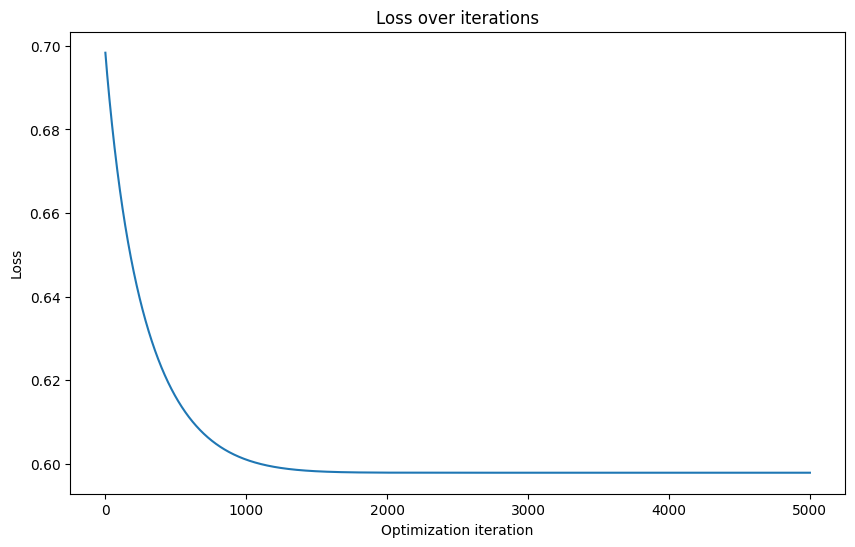

In [9]:
import torch
import matplotlib.pyplot as plt

# Assuming X and Y are DataFrames
Xvalues = X.values  # Convert DataFrame to NumPy array
Yvalues = Y.values  # Convert DataFrame to NumPy array

# Convert to tensors
x_tensor = torch.tensor(Xvalues, dtype=torch.float32)
y_tensor = torch.tensor(Yvalues, dtype=torch.float32).reshape(-1, 1)

learning_rate = .00125
losses = []
params = []
D_in = X.shape[1]
D_out = 1
# Define the model
model = torch.nn.Sequential(
    torch.nn.Linear(D_in, D_out),  # First layer (input -> hidden)
    torch.nn.Sigmoid(),            # Activation after first layer
)

# Define loss function and optimizer
loss_fn = torch.nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Carry out gradient descent 
for i in range(5000 + 1):
    # Forward pass: compute predicted y
    y_pred = model(x_tensor)
    
    # Compute and store loss, and print occasionally 
    loss = loss_fn(y_pred, y_tensor)
    losses.append(loss.item())
    if i % 50 == 0:
        print(f"iteration {i}: loss = {loss.item():.4f}")

    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Store parameters
    params.append([param.detach().numpy() for param in model.parameters()])

print(f"Final loss: {loss.item():.4f}")

# Plot the loss
plt.figure(figsize=(10, 6))
plt.plot(range(0, len(losses)), losses)
plt.xlabel("Optimization iteration")
plt.ylabel("Loss")
plt.title("Loss over iterations")
plt.show()


Training the neural network was pretty straightforwards, I considered adding more layers, but it led to some really funky loss curves.\
While the log loss of this model is lower, meaning it should be more accurate, this doesn't really end up bearing out in the results.\
The output of the model has been kind of variable on repeated testing. It got a little better when I turned down the step size.\


In [10]:
import itertools

# Get unique values for each column
genders = df['gender'].unique()
race_ethnicities = df['race_ethnicity'].unique()
parental_education_levels = df['parental_level_of_education'].unique()
lunch_categories = df['lunch'].unique()
test_preparation_course = df['test_preparation_course'].unique()

# Generate all permutations
permutations = list(itertools.product(
    genders,
    race_ethnicities,
    parental_education_levels,
    lunch_categories,
    test_preparation_course
))

# Create a new DataFrame from the permutations
df_permutations = pd.DataFrame(
    permutations,
    columns=[
        'gender',
        'race_ethnicity',
        'parental_level_of_education',
        'lunch',
        'test_preparation_course'
    ]
)


# Print to verify

# One-hot encode the categorical features
x_permutations = pd.get_dummies(df_permutations, columns = ['parental_level_of_education','race_ethnicity'],dtype=float)

# generate gbc predictions
y_permutations = gbc.predict_proba(x_permutations)[:, 1]
# Add the probabilities to the DataFrame of permutations
df_permutations['gbc_pass_probability'] = y_permutations   
# add gbc_pass column to df_permutations, 1 if the probability is greater than 0.5, 0 otherwise
df_permutations['gbc_pass'] = (y_permutations > 0.5).astype(int)
# Convert the DataFrame to a NumPy array
x_permutations = x_permutations.values
# convert to tensor 
x_permutations_tensor = torch.tensor(x_permutations, dtype=torch.float32)
# Predict the probabilities of passing for all permutations using the trained model
y_permutations_tensor = model(x_permutations_tensor)
y_permutations = y_permutations_tensor.detach().numpy()
# Add the probabilities to the DataFrame of permutations
df_permutations['neural_pass_probability'] = y_permutations
df_permutations['neural_pass'] = (y_permutations > 0.5).astype(int)

#export df_permutations to a csv file
df_permutations.to_csv('Predicted_Student_Performance.csv', index=False)